# Analysis

This notebook analysis the results of the FL experiments, beginning with the first stage results. It will not only contain code and graphics, but also text describing the findings. This is in order to find the proper direction of research and to make writing the thesis chapter more easier afterwards.
The first stage analyses a wide range of FL models. The idea is to find similarities and differences between them. Therefore, this part heavily emphasizes on desprictive statistics of the collection of results.
The second stage focuses on specific results. The underlying model is more examined and potentential reasons for the unusual performances are considered. 

## Stage One - A Broad View on the Results 

In [1]:
#import libraries
import scipy
import numpy as np
import pandas as pd

import tensorflow as tf
import sklearn as sk

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

2023-03-05 18:06:45.996130: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-05 18:06:47.721404: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-05 18:06:47.722152: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-05 18:06:47.722169: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
#load data
df = pd.read_json("../covid_logs.json")
df.head()

,date,model,dataset,rounds,losses_distributed,centralized_loss,time,number_of_clients,entries,number_of_samples,attributes,stations,scenario,percentage_of_testing_data,loss,epochs,hidden_layers,batch_size
0,1970-01-01,MLP,covid,2,"[[1, 0.029264979700000002], [2, 0.055490080500...",NaN,"[[1, 9500.9945039], [2, 9507.7672474]]",2,10,100000,"[new_cases, weekly_hosp_admissions]",[berlin],separate,0.2,MAE,10,2,500
1,1970-01-01,MLP,covid,2,"[[1, 0.0515487829], [2, 0.028769035000000002]]",NaN,"[[1, 9516.299327], [2, 9520.3183962]]",2,10,100000,"[new_cases, weekly_hosp_admissions]",[berlin],separate,0.2,MAE,10,2,1000
2,1970-01-01,MLP,covid,2,"[[1, 0.030558266100000002], [2, 0.0425953164]]",NaN,"[[1, 9532.5769273], [2, 9540.4314527]]",2,10,100000,"[new_cases, weekly_hosp_admissions]",[berlin],separate,0.2,MAE,10,3,500
3,1970-01-01,MLP,covid,2,"[[1, 0.0963110199], [2, 0.0295671737]]",NaN,"[[1, 9549.510162], [2, 9554.0862643]]",2,10,100000,"[new_cases, weekly_hosp_admissions]",[berlin],separate,0.2,MAE,10,3,1000
4,1970-01-01,MLP,covid,2,"[[1, 0.0678201869], [2, 0.0297109118]]",NaN,"[[1, 9567.3016049], [2, 9576.0287391]]",2,10,100000,"[new_cases, weekly_hosp_admissions]",[berlin],separate,0.2,MAE,10,4,500


In [3]:
#print information
print(f"""
Length: {len(df.index)}
Covid entries: {len(df[df.dataset == "covid"].index)}
Weather entries: {len(df[df.dataset == "weather"].index)}
Contains Nans: {df.isnull().values.any()}
""")


Length: 108
Covid entries: 108
Weather entries: 0
Contains Nans: True



In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rounds,108.0,6.0,4.018648e+00,2.0,2.0,6.0,10.0,10.0
centralized_loss,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
number_of_clients,108.0,3.0,8.203031e-01,2.0,2.0,3.0,4.0,4.0
entries,108.0,10.0,0.000000e+00,10.0,10.0,10.0,10.0,10.0
number_of_samples,108.0,100000.0,0.000000e+00,100000.0,100000.0,100000.0,100000.0,100000.0
percentage_of_testing_data,108.0,0.2,2.788497e-17,0.2,0.2,0.2,0.2,0.2
epochs,108.0,10.0,0.000000e+00,10.0,10.0,10.0,10.0,10.0
hidden_layers,108.0,3.0,8.203031e-01,2.0,2.0,3.0,4.0,4.0
batch_size,108.0,750.0,2.511655e+02,500.0,500.0,750.0,1000.0,1000.0


The next part examines characteristics of each use case. 

### Covid dataset

In [5]:
#get horizontal use case
covid_df = df[df.dataset == "covid"]

In [6]:
#print general information
print(f"""
MLP entries: {len(covid_df[covid_df.model == "MLP"].index)}
LSTM entries: {len(covid_df[covid_df.model == "LSTM"].index)}
CNN entries: {len(covid_df[covid_df.model == "CNN"].index)}
""")


MLP entries: 36
LSTM entries: 36
CNN entries: 36



The first interesting is to see how well the best model of every algorithm performed.

In [7]:
models = ["MLP", "LSTM", "CNN"]
best_covid_performance = pd.DataFrame(columns=covid_df.columns)
for i, model in enumerate(models):
    df_copy = covid_df[covid_df.model == model].copy(deep=True)
    df_copy["losses_distributed"] = df_copy["losses_distributed"].apply(lambda x: x[-1][-1])
    best_covid_performance = pd.concat([best_covid_performance, df_copy.sort_values(by=["losses_distributed"], ascending=True).iloc[0:1, :]], ignore_index=True)

best_covid_performance.head()
    

,date,model,dataset,rounds,losses_distributed,centralized_loss,time,number_of_clients,entries,number_of_samples,attributes,stations,scenario,percentage_of_testing_data,loss,epochs,hidden_layers,batch_size
0,1970-01-01,MLP,covid,10,0.019430,NaN,"[[1, 10436.9705556], [2, 10441.0387492], [3, 1...",2,10,100000,"[new_cases, weekly_hosp_admissions]",[berlin],separate,0.2,MAE,10,2,1000
1,1970-01-01,LSTM,covid,10,0.059161,NaN,"[[1, 16983.5689522], [2, 17033.8439814], [3, 1...",3,10,100000,"[new_cases, weekly_hosp_admissions, new_deaths]",[berlin],separate,0.2,MAE,10,2,1000
2,1970-01-01,CNN,covid,10,0.021144,NaN,"[[1, 13963.30825], [2, 13974.5065781], [3, 139...",2,10,100000,"[new_cases, weekly_hosp_admissions]",[berlin],separate,0.2,MAE,10,3,500


In [8]:
models = ["MLP", "LSTM", "CNN"]
features = [2,3,4]
best_covid_performance_detailed = pd.DataFrame(columns=covid_df.columns)

#loop over number of features
for feature in features:
    #loop over models
    for i, model in enumerate(models):
        df_copy = covid_df[(covid_df.model == model) & (covid_df.number_of_clients == feature)].copy(deep=True)
        df_copy["losses_distributed"] = df_copy["losses_distributed"].apply(lambda x: x[-1][-1])
        best_covid_performance_detailed = pd.concat([best_covid_performance_detailed, df_copy.sort_values(by=["losses_distributed"], ascending=True).iloc[0:1, :]], ignore_index=True)

best_covid_performance_detailed

,date,model,dataset,rounds,losses_distributed,centralized_loss,time,number_of_clients,entries,number_of_samples,attributes,stations,scenario,percentage_of_testing_data,loss,epochs,hidden_layers,batch_size
0,1970-01-01,MLP,covid,10,0.019430,NaN,"[[1, 10436.9705556], [2, 10441.0387492], [3, 1...",2,10,100000,"[new_cases, weekly_hosp_admissions]",[berlin],separate,0.2,MAE,10,2,1000
1,1970-01-01,LSTM,covid,2,0.073867,NaN,"[[1, 9908.5229879], [2, 9950.3854158]]",2,10,100000,"[new_cases, weekly_hosp_admissions]",[berlin],separate,0.2,MAE,10,3,1000
2,1970-01-01,CNN,covid,10,0.021144,NaN,"[[1, 13963.30825], [2, 13974.5065781], [3, 139...",2,10,100000,"[new_cases, weekly_hosp_admissions]",[berlin],separate,0.2,MAE,10,3,500
3,1970-01-01,MLP,covid,10,0.020142,NaN,"[[1, 15809.3067427], [2, 15815.6610039], [3, 1...",3,10,100000,"[new_cases, weekly_hosp_admissions, new_deaths]",[berlin],separate,0.2,MAE,10,2,1000
4,1970-01-01,LSTM,covid,10,0.059161,NaN,"[[1, 16983.5689522], [2, 17033.8439814], [3, 1...",3,10,100000,"[new_cases, weekly_hosp_admissions, new_deaths]",[berlin],separate,0.2,MAE,10,2,1000
5,1970-01-01,CNN,covid,10,0.030160,NaN,"[[1, 21124.3598268], [2, 21133.0206787], [3, 2...",3,10,100000,"[new_cases, weekly_hosp_admissions, new_deaths]",[berlin],separate,0.2,MAE,10,2,1000
6,1970-01-01,MLP,covid,10,0.020827,NaN,"[[1, 23728.7387743], [2, 23736.9214091], [3, 2...",4,10,100000,"[new_cases, weekly_hosp_admissions, new_deaths...",[berlin],separate,0.2,MAE,10,2,1000
7,1970-01-01,LSTM,covid,10,0.059224,NaN,"[[1, 25230.3573414], [2, 25290.602732], [3, 25...",4,10,100000,"[new_cases, weekly_hosp_admissions, new_deaths...",[berlin],separate,0.2,MAE,10,2,1000
8,1970-01-01,CNN,covid,2,0.026836,NaN,"[[1, 23369.3937478], [2, 23381.021367]]",4,10,100000,"[new_cases, weekly_hosp_admissions, new_deaths...",[berlin],separate,0.2,MAE,10,2,1000


The results match the expectations. The linear models can understand the underlying structure of the data. But the neural-network based models more capable in adapting to it. Interestingly, the MLP had the best performance. But in general the differences are minor.

<AxesSubplot: xlabel='model', ylabel='losses_distributed'>

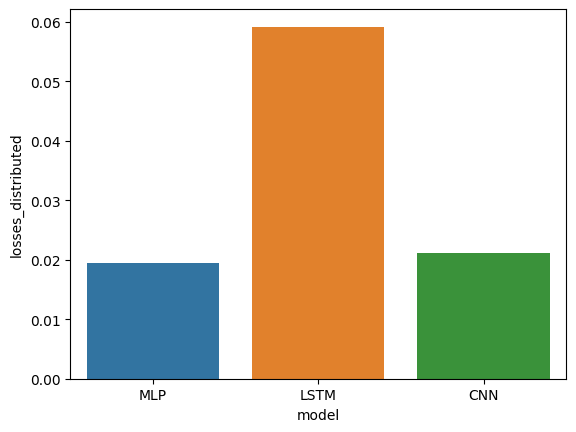

In [9]:
sns.barplot(data=best_covid_performance, x="model", y="losses_distributed")

In [10]:
best_covid_performance

,date,model,dataset,rounds,losses_distributed,centralized_loss,time,number_of_clients,entries,number_of_samples,attributes,stations,scenario,percentage_of_testing_data,loss,epochs,hidden_layers,batch_size
0,1970-01-01,MLP,covid,10,0.019430,NaN,"[[1, 10436.9705556], [2, 10441.0387492], [3, 1...",2,10,100000,"[new_cases, weekly_hosp_admissions]",[berlin],separate,0.2,MAE,10,2,1000
1,1970-01-01,LSTM,covid,10,0.059161,NaN,"[[1, 16983.5689522], [2, 17033.8439814], [3, 1...",3,10,100000,"[new_cases, weekly_hosp_admissions, new_deaths]",[berlin],separate,0.2,MAE,10,2,1000
2,1970-01-01,CNN,covid,10,0.021144,NaN,"[[1, 13963.30825], [2, 13974.5065781], [3, 139...",2,10,100000,"[new_cases, weekly_hosp_admissions]",[berlin],separate,0.2,MAE,10,3,500


What is the average performance?

In [11]:
average_covid_performance = {"MLP": 0, "LSTM": 0, "CNN": 0}
for  model in models:
    df_copy = covid_df[covid_df.model == model].copy(deep=True)
    df_copy["losses_distributed"] = df_copy["losses_distributed"].apply(lambda x: x[-1][-1])
    average_covid_performance[model] = df_copy["losses_distributed"].mean()

average_covid_performance = pd.DataFrame(list(average_covid_performance.items()), columns=["model", "losses_distributed"])

<AxesSubplot: xlabel='model', ylabel='losses_distributed'>

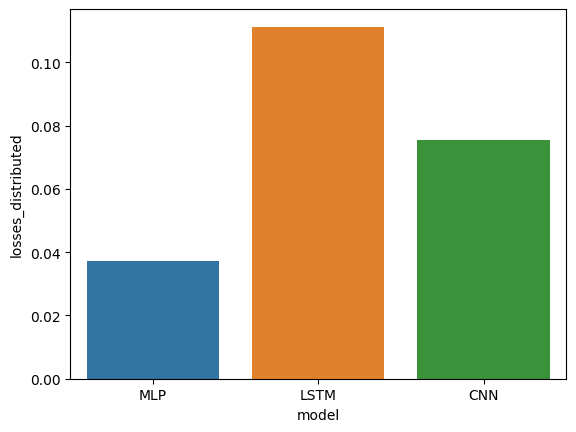

In [12]:
sns.barplot(average_covid_performance, x="model", y="losses_distributed")

In [13]:
average_covid_performance.head()

,model,losses_distributed
0,MLP,0.037261
1,LSTM,0.111264
2,CNN,0.075456


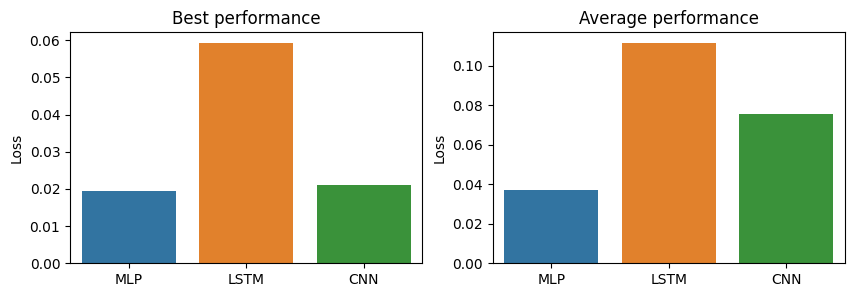

In [24]:
fig, axes = plt.subplots(1,2, figsize=(10,3))

sns.barplot(data=best_covid_performance, x="model", y="losses_distributed", ax=axes[0])

axes[0].set_xlabel("")
axes[0].set_ylabel("Loss")
axes[0].set_title("Best performance")

sns.barplot(average_covid_performance, x="model", y="losses_distributed", ax=axes[1])

axes[1].set_xlabel("")
axes[1].set_ylabel("Loss")
axes[1].set_title("Average performance")


plt.savefig("exports/covid/covid_fl_performance.svg")
plt.show()

In [25]:
results_only_df = covid_df.copy(deep=True)
results_only_df["losses_distributed"] = results_only_df["losses_distributed"].apply(lambda x: x[-1][-1])

results_only_two_features_df = results_only_df[results_only_df.number_of_clients == 2]
results_only_three_features_df = results_only_df[results_only_df.number_of_clients == 3]
results_only_four_features_df = results_only_df[results_only_df.number_of_clients == 4]

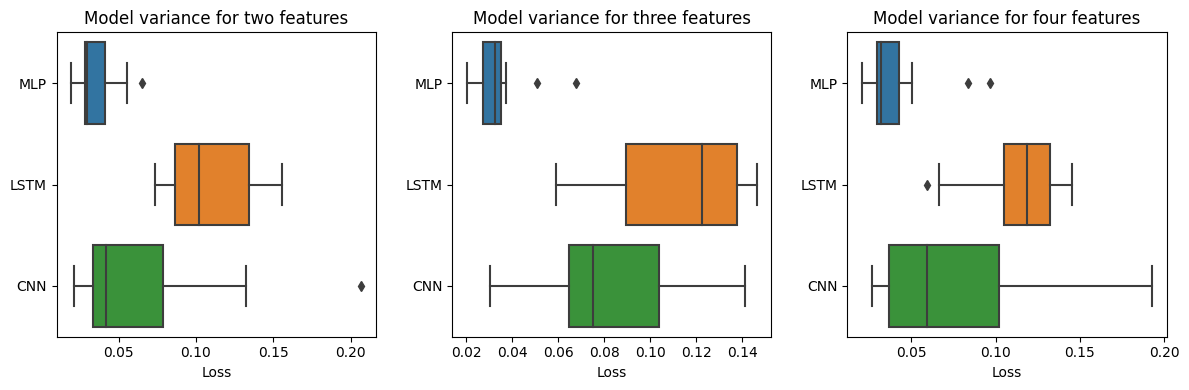

In [26]:
fig, axes = plt.subplots(1,3, figsize=(12,4))

sns.boxplot(data=results_only_two_features_df, x="losses_distributed", y="model", ax=axes[0])
axes[0].set_title("Model variance for two features")
axes[0].set_ylabel("")
axes[0].set_xlabel("Loss")

sns.boxplot(data=results_only_three_features_df, x="losses_distributed", y="model", ax=axes[1])
axes[1].set_title("Model variance for three features")
axes[1].set_ylabel("")
axes[1].set_xlabel("Loss")

sns.boxplot(data=results_only_four_features_df, x="losses_distributed", y="model", ax=axes[2])
axes[2].set_title("Model variance for four features")
axes[2].set_ylabel("")
axes[2].set_xlabel("Loss")

plt.tight_layout()

plt.savefig("exports/covid/covid_fl_variance.svg")
plt.show()

In [27]:
_, p_value = scipy.stats.levene(results_only_two_features_df[results_only_two_features_df.model == "LSTM"]["losses_distributed"], results_only_two_features_df[results_only_two_features_df.model == "CNN"]["losses_distributed"])
print(f'Two clients: {p_value}')

_, p_value = scipy.stats.levene(results_only_three_features_df[results_only_three_features_df.model == "LSTM"]["losses_distributed"], results_only_three_features_df[results_only_three_features_df.model == "CNN"]["losses_distributed"])
print(f'Three clients: {p_value}')

_, p_value = scipy.stats.levene(results_only_four_features_df[results_only_four_features_df.model == "LSTM"]["losses_distributed"], results_only_four_features_df[results_only_four_features_df.model == "CNN"]["losses_distributed"])
print(f'Four clients: {p_value}')

Two clients: 0.4296682562966593
Three clients: 0.7835107207903642
Four clients: 0.12937151254394644


Does the number of rounds impact the model performance?

Two features: 0.07909826263265422
Two features var: 0.27095952465145057
Three features: 0.2481686938067007
Three features var: 0.3027165379656557
Four features: 0.04453171574303838
Four features var: 0.029879833931448437


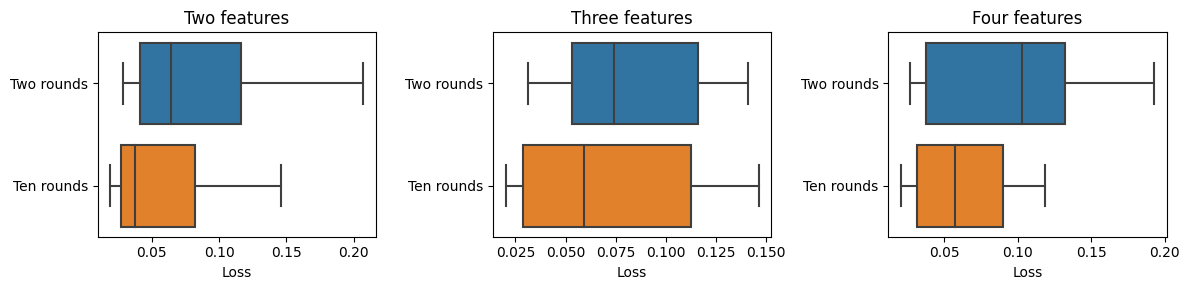

In [28]:
fig, axes = plt.subplots(1,3, figsize=(12,3))

#two features
two_rounds_df = results_only_two_features_df[results_only_two_features_df.rounds == 2].reset_index()
ten_rounds_df = results_only_two_features_df[results_only_two_features_df.rounds == 10].reset_index()

num_of_rounds_diff_df = pd.DataFrame({"Two rounds": two_rounds_df.losses_distributed, "Ten rounds": ten_rounds_df.losses_distributed})
sns.boxplot(num_of_rounds_diff_df, ax=axes[0], orient="h")
axes[0].set_title("Two features")
axes[0].set_xlabel("Loss")

_, p_value = scipy.stats.mannwhitneyu(num_of_rounds_diff_df["Two rounds"], num_of_rounds_diff_df["Ten rounds"])
print(f'Two features: {p_value}')

_, p_value = scipy.stats.levene(num_of_rounds_diff_df["Two rounds"], num_of_rounds_diff_df["Ten rounds"])
print(f'Two features var: {p_value}')

#three features
two_rounds_df = results_only_three_features_df[results_only_three_features_df.rounds == 2].reset_index()
ten_rounds_df = results_only_three_features_df[results_only_three_features_df.rounds == 10].reset_index()

num_of_rounds_diff_df = pd.DataFrame({"Two rounds": two_rounds_df.losses_distributed, "Ten rounds": ten_rounds_df.losses_distributed})
sns.boxplot(num_of_rounds_diff_df, ax=axes[1], orient="h")
axes[1].set_title("Three features")
axes[1].set_xlabel("Loss")

_, p_value = scipy.stats.mannwhitneyu(num_of_rounds_diff_df["Two rounds"], num_of_rounds_diff_df["Ten rounds"])
print(f'Three features: {p_value}')

_, p_value = scipy.stats.levene(num_of_rounds_diff_df["Two rounds"], num_of_rounds_diff_df["Ten rounds"])
print(f'Three features var: {p_value}')

#four features
two_rounds_df = results_only_four_features_df[results_only_four_features_df.rounds == 2].reset_index()
ten_rounds_df = results_only_four_features_df[results_only_four_features_df.rounds == 10].reset_index()

num_of_rounds_diff_df = pd.DataFrame({"Two rounds": two_rounds_df.losses_distributed, "Ten rounds": ten_rounds_df.losses_distributed})
sns.boxplot(num_of_rounds_diff_df, ax=axes[2], orient="h")
axes[2].set_title("Four features")
axes[2].set_xlabel("Loss")

_, p_value = scipy.stats.mannwhitneyu(num_of_rounds_diff_df["Two rounds"], num_of_rounds_diff_df["Ten rounds"])
print(f'Four features: {p_value}')

_, p_value = scipy.stats.levene(num_of_rounds_diff_df["Two rounds"], num_of_rounds_diff_df["Ten rounds"])
print(f'Four features var: {p_value}')

#plot figure
plt.tight_layout()
plt.xlabel("Loss")

plt.savefig("exports/covid/covid_fl_training_rounds.svg")
plt.show()

In [29]:
num_of_rounds_diff_df

,Two rounds,Ten rounds
0,0.050250,0.030578
1,0.032248,0.020827
2,0.030101,0.083777
3,0.033334,0.024940
4,0.040527,0.031883
5,0.096650,0.028369
6,0.140648,0.066747
7,0.109099,0.059224
8,0.132255,0.118251
9,0.132318,0.092236


The number of rounds seems to have an impact on performance. The average is almost the same, but the tails are different. Four rounds has a fat tail on the left, while the two rounds distribution has one on the right. What the skew and kurosis of the distributions?

In [30]:
print(f"""
Two rounds skew: {two_rounds_df.losses_distributed.skew()}
Two rounds kurosis: {two_rounds_df.losses_distributed.kurtosis()}
Ten rounds skew: {ten_rounds_df.losses_distributed.skew()}
Ten rounds kurtosis: {ten_rounds_df.losses_distributed.kurtosis()}
""")


Two rounds skew: 0.078315143352302
Two rounds kurosis: -1.2351674844179397
Ten rounds skew: 0.5031613832245312
Ten rounds kurtosis: -1.1244711303873167



Training with two rounds creates a left-skewed distribution with a high kurosis of around 5.7. It has an excess kurtosis of 2.7 and is therefore leptokurtic.
Training with four rounds creates a slightly right-skewed distribution and has a small negative kurtosis of around 0.3.

Next, let's look at the average training time. First, we need to find the best parameters for every scenario (2,3 or 4 features).

In [31]:
def calculate_training_time(time_array):
    #get the timestamps
    timestamps = []
    for el in time_array:
        timestamps.append(el[-1])
    
    #calculate difference
    diff = []
    for i in range(len(timestamps)):
        if i == len(timestamps)-1:
            break
        diff.append((timestamps[i+1] - timestamps[i]))
    return diff

time_diff_df = covid_df.copy(deep=True)
time_diff_df["time"] = time_diff_df["time"].apply(calculate_training_time)

In [32]:
time_average_df = time_diff_df
time_average_df["time"] = time_average_df["time"].apply(lambda x: np.array(x).mean())

In [33]:
average_time_performance = {"MLP": 0, "LSTM": 0, "CNN": 0}
for  model in models:
    df = time_average_df[time_average_df.model == model]
    average_time_performance[model] = df["time"].mean()

average_time_performance = pd.DataFrame(list(average_time_performance.items()), columns=["model", "time"])
average_time_performance.head()

,model,time
0,MLP,9.202822
1,LSTM,76.925340
2,CNN,13.849946


<AxesSubplot: xlabel='model', ylabel='time'>

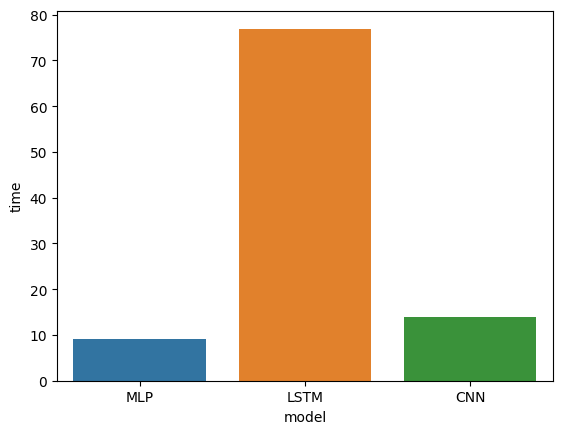

In [34]:
sns.barplot(average_time_performance, x="model", y="time")

How big is the variance in training time?

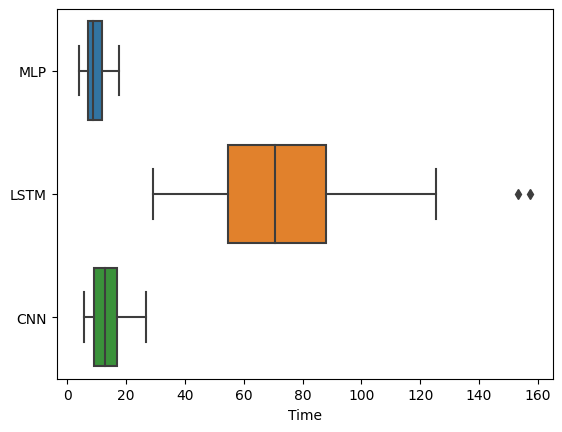

In [35]:
sns.boxplot(data=time_diff_df, x="time", y="model")

plt.ylabel("")
plt.xlabel("Time")

plt.savefig("exports/covid/covid_fl_time.svg")
plt.show()

In [36]:
time_diff_df[time_diff_df.model == "LSTM"].time.mean()

76.92533963765429

Text(0.5, 0, 'Time')

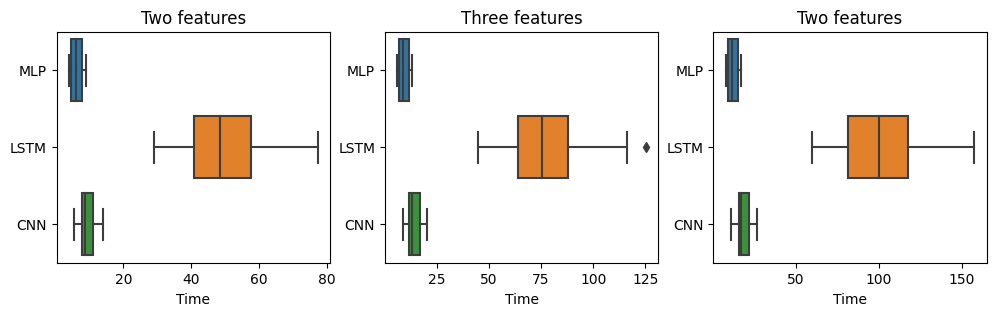

In [37]:
fig, axes = plt.subplots(1,3, figsize=(12,3))


sns.boxplot(data=time_diff_df[time_diff_df.number_of_clients == 2], x="time", y="model", ax=axes[0])
axes[0].set_title("Two features")
axes[0].set_ylabel("")
axes[0].set_xlabel("Time")

sns.boxplot(data=time_diff_df[time_diff_df.number_of_clients == 3], x="time", y="model", ax=axes[1])
axes[1].set_title("Three features")
axes[1].set_ylabel("")
axes[1].set_xlabel("Time")

sns.boxplot(data=time_diff_df[time_diff_df.number_of_clients == 4], x="time", y="model", ax=axes[2])
axes[2].set_title("Two features")
axes[2].set_ylabel("")
axes[2].set_xlabel("Time")


Now lets compare the models with the baseline. First, all FL models are compared to the baselines. It is likely they perform worse on average because of their hyperparameters. After that the best models, as well as the models with optimal hyperparameters are selected, trained multiple times to minimize the effect of random initialization and then compared. 

In [38]:
import json

with open('exports/covid/covid_baselines.json') as data:
    baselines = json.load(data)
    data.close()

In [39]:
dfs = []
for model, data in baselines.items():
    df = pd.DataFrame.from_dict(data)
    df['model'] = model
    dfs.append(df)

baseline_df = pd.concat(dfs, axis=0, ignore_index=True)
baseline_df.head()

,client_data1,client_time1,client_data2,client_time2,client_data3,client_time3,client_data4,client_time4,model
0,0.024297,"[547.2120742, 550.0158308, 553.5174664, 556.30...",0.026645,"[653.1074504, 655.8522954, 658.6090376, 661.46...",0.045126,"[775.0793905, 780.4436325, 785.6950818, 791.00...",0.032125,"[986.0609658, 988.9099086, 991.6851549, 994.36...",MLP
1,0.022426,"[575.6638244, 578.3563697, 580.8960252, 583.45...",0.029665,"[688.8833417, 691.7778715, 694.589534, 697.340...",0.037161,"[828.3932195, 833.6879771, 838.9129903, 844.71...",0.029739,"[1013.3798491, 1015.9912445, 1018.594147, 1021...",MLP
2,0.024592,"[601.2217089, 603.7450796, 606.3623556, 608.87...",0.030154,"[716.5711463, 719.2586925, 721.9865047, 724.69...",0.044719,"[882.0689031, 887.6206802, 892.8869023, 898.11...",0.030546,"[1039.7111097, 1042.3307512, 1044.9314687, 104...",MLP
3,0.024328,"[626.4604915, 629.0308533, 631.5411903, 634.03...",0.024513,"[744.1544746, 746.8512264, 749.5428587, 752.25...",0.048123,"[935.0691518, 940.3023482, 945.4816158, 950.67...",0.031338,"[1066.0733708, 1068.6763922, 1071.2439764, 107...",MLP
4,0.031163,"[2555.0621558, 2572.4610659, 2589.9047807, 260...",0.037183,"[3270.8321863, 3295.7757734, 3320.6279946, 334...",0.043159,"[4279.5727219, 4313.324576, 4346.6557017, 4380...",0.035436,"[5631.9413491, 5656.5498561, 5681.1791943, 570...",LSTM


In [40]:
baseline_averages = baseline_df.groupby("model").mean()
baseline_averages

/tmp/ipykernel_396/4100221437.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  baseline_averages = baseline_df.groupby("model").mean()


,client_data1,client_data2,client_data3,client_data4
model,,,,
CNN,0.030558,0.023310,0.042258,0.030922
LSTM,0.031552,0.037750,0.043084,0.034729
MLP,0.023911,0.027744,0.043782,0.030937


<AxesSubplot: ylabel='Density'>

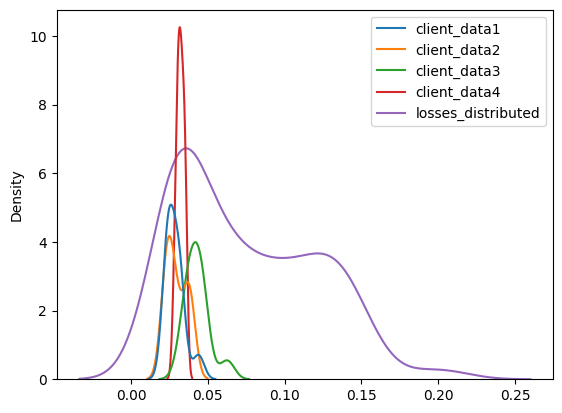

In [41]:
temp_df = baseline_df.copy(deep=True)
temp_df["model"] = temp_df["model"].apply(lambda x: f'{x} basline')
#fig = sns.boxplot(temp_df, x="client_data4", y="model")
#fig = sns.boxplot(results_only_df, x="losses_distributed", y="model")
#plt.show()

fig, ax = plt.subplots()
sns.kdeplot(data=[temp_df["client_data1"], temp_df["client_data2"], temp_df["client_data3"], temp_df["client_data4"], results_only_df["losses_distributed"]], ax=ax)

In [42]:
print(f"""
Mean baseline for data of 1 client: {baseline_averages["client_data1"].mean()}
Mean baseline for data of 2 clients: {baseline_averages["client_data2"].mean()}
Mean baseline for data of 3 clients: {baseline_averages["client_data3"].mean()}
Mean baseline for data of 4 clients: {baseline_averages["client_data4"].mean()}
------------------------------------------------------------------------------
Mean for FL with 2 clients: {results_only_two_features_df["losses_distributed"].mean()}
Mean for FL with 4 clients: {results_only_four_features_df["losses_distributed"].mean()}
""")


Mean baseline for data of 1 client: 0.028673528643548708
Mean baseline for data of 2 clients: 0.02960157937037972
Mean baseline for data of 3 clients: 0.043041372395115705
Mean baseline for data of 4 clients: 0.0321959055277451
------------------------------------------------------------------------------
Mean for FL with 2 clients: 0.07024044974722221
Mean for FL with 4 clients: 0.07753932685277777



In [43]:
results_only_two_features_df[(results_only_two_features_df.model == "CNN") & (results_only_two_features_df.batch_size == 500)]["losses_distributed"]

12    0.035168
14    0.206964
16    0.041824
30    0.026495
32    0.021144
34    0.033503
Name: losses_distributed, dtype: float64

In [44]:
baseline_averages

,client_data1,client_data2,client_data3,client_data4
model,,,,
CNN,0.030558,0.023310,0.042258,0.030922
LSTM,0.031552,0.037750,0.043084,0.034729
MLP,0.023911,0.027744,0.043782,0.030937


In [45]:
_, p_value = scipy.stats.mannwhitneyu(results_only_two_features_df["losses_distributed"].to_numpy(), baseline_df["client_data2"].to_numpy())
print(p_value)

0.0020469573285851615


The data suggests that combining data from multiple weather stations and training them centrally actually decreases the accuracy of the model. This does not seem to be the case for the FL setting. How does the skewness and kurosis looks for the distributions?

In [46]:
baseline_fl_dist_df = pd.DataFrame(([["Baseline 1 clients data", baseline_averages["client_data1"].mean(), baseline_averages["client_data1"].std(), baseline_averages["client_data1"].skew(), baseline_averages["client_data1"].kurtosis()],
    ["Baseline 2 clients data", baseline_averages["client_data2"].mean(), baseline_averages["client_data2"].std(), baseline_averages["client_data2"].skew(), baseline_averages["client_data2"].kurtosis()],
    ["Baseline 3 clients data", baseline_averages["client_data3"].mean(), baseline_averages["client_data3"].std(), baseline_averages["client_data3"].skew(), baseline_averages["client_data3"].kurtosis()],
    ["Baseline 4 clients data", baseline_averages["client_data4"].mean(), baseline_averages["client_data4"].std(), baseline_averages["client_data4"].skew(), baseline_averages["client_data4"].kurtosis()],
    ["FL with 2 clients", results_only_two_features_df["losses_distributed"].mean(), results_only_two_features_df["losses_distributed"].std(), results_only_two_features_df["losses_distributed"].skew(), results_only_two_features_df["losses_distributed"].kurtosis()],
    ["FL with 4 clients", results_only_four_features_df["losses_distributed"].mean(), results_only_four_features_df["losses_distributed"].std(), results_only_four_features_df["losses_distributed"].skew(), results_only_four_features_df["losses_distributed"].kurtosis()]
]), columns=["scenario", "mean", "std", "skew", "kurtosis"])

baseline_fl_dist_df

,scenario,mean,std,skew,kurtosis
0,Baseline 1 clients data,0.028674,0.004154,-1.621359,NaN
1,Baseline 2 clients data,0.029602,0.007397,1.058751,NaN
2,Baseline 3 clients data,0.043041,0.000763,-0.251618,NaN
3,Baseline 4 clients data,0.032196,0.002194,1.731961,NaN
4,FL with 2 clients,0.070240,0.047600,1.030343,0.385828
5,FL with 4 clients,0.077539,0.045782,0.525798,-0.740646


In [47]:
time_diff_df.head()

,date,model,dataset,rounds,losses_distributed,centralized_loss,time,number_of_clients,entries,number_of_samples,attributes,stations,scenario,percentage_of_testing_data,loss,epochs,hidden_layers,batch_size
0,1970-01-01,MLP,covid,2,"[[1, 0.029264979700000002], [2, 0.055490080500...",NaN,6.772743,2,10,100000,"[new_cases, weekly_hosp_admissions]",[berlin],separate,0.2,MAE,10,2,500
1,1970-01-01,MLP,covid,2,"[[1, 0.0515487829], [2, 0.028769035000000002]]",NaN,4.019069,2,10,100000,"[new_cases, weekly_hosp_admissions]",[berlin],separate,0.2,MAE,10,2,1000
2,1970-01-01,MLP,covid,2,"[[1, 0.030558266100000002], [2, 0.0425953164]]",NaN,7.854525,2,10,100000,"[new_cases, weekly_hosp_admissions]",[berlin],separate,0.2,MAE,10,3,500
3,1970-01-01,MLP,covid,2,"[[1, 0.0963110199], [2, 0.0295671737]]",NaN,4.576102,2,10,100000,"[new_cases, weekly_hosp_admissions]",[berlin],separate,0.2,MAE,10,3,1000
4,1970-01-01,MLP,covid,2,"[[1, 0.0678201869], [2, 0.0297109118]]",NaN,8.727134,2,10,100000,"[new_cases, weekly_hosp_admissions]",[berlin],separate,0.2,MAE,10,4,500


In [48]:
models = ["MLP", "LSTM", "CNN"]
clients = [2,3,4]
best_covid_performance_per_scenario = []

for i in clients:
    for model in models:
        df_copy = covid_df[(covid_df.model == model) & (covid_df.number_of_clients == i)].copy()
        df_copy["losses_distributed"] = df_copy["losses_distributed"].apply(lambda x: x[-1][-1])
        df_copy = df_copy.sort_values(by=["losses_distributed"], ascending=True).iloc[0:1, :]
        best_covid_performance_per_scenario.append(df_copy)

best_covid_performance_per_scenario = pd.concat(best_covid_performance_per_scenario, ignore_index=True)

In [49]:
best_covid_performance_per_scenario

,date,model,dataset,rounds,losses_distributed,centralized_loss,time,number_of_clients,entries,number_of_samples,attributes,stations,scenario,percentage_of_testing_data,loss,epochs,hidden_layers,batch_size
0,1970-01-01,MLP,covid,10,0.019430,NaN,"[[1, 10436.9705556], [2, 10441.0387492], [3, 1...",2,10,100000,"[new_cases, weekly_hosp_admissions]",[berlin],separate,0.2,MAE,10,2,1000
1,1970-01-01,LSTM,covid,2,0.073867,NaN,"[[1, 9908.5229879], [2, 9950.3854158]]",2,10,100000,"[new_cases, weekly_hosp_admissions]",[berlin],separate,0.2,MAE,10,3,1000
2,1970-01-01,CNN,covid,10,0.021144,NaN,"[[1, 13963.30825], [2, 13974.5065781], [3, 139...",2,10,100000,"[new_cases, weekly_hosp_admissions]",[berlin],separate,0.2,MAE,10,3,500
3,1970-01-01,MLP,covid,10,0.020142,NaN,"[[1, 15809.3067427], [2, 15815.6610039], [3, 1...",3,10,100000,"[new_cases, weekly_hosp_admissions, new_deaths]",[berlin],separate,0.2,MAE,10,2,1000
4,1970-01-01,LSTM,covid,10,0.059161,NaN,"[[1, 16983.5689522], [2, 17033.8439814], [3, 1...",3,10,100000,"[new_cases, weekly_hosp_admissions, new_deaths]",[berlin],separate,0.2,MAE,10,2,1000
5,1970-01-01,CNN,covid,10,0.030160,NaN,"[[1, 21124.3598268], [2, 21133.0206787], [3, 2...",3,10,100000,"[new_cases, weekly_hosp_admissions, new_deaths]",[berlin],separate,0.2,MAE,10,2,1000
6,1970-01-01,MLP,covid,10,0.020827,NaN,"[[1, 23728.7387743], [2, 23736.9214091], [3, 2...",4,10,100000,"[new_cases, weekly_hosp_admissions, new_deaths...",[berlin],separate,0.2,MAE,10,2,1000
7,1970-01-01,LSTM,covid,10,0.059224,NaN,"[[1, 25230.3573414], [2, 25290.602732], [3, 25...",4,10,100000,"[new_cases, weekly_hosp_admissions, new_deaths...",[berlin],separate,0.2,MAE,10,2,1000
8,1970-01-01,CNN,covid,2,0.026836,NaN,"[[1, 23369.3937478], [2, 23381.021367]]",4,10,100000,"[new_cases, weekly_hosp_admissions, new_deaths...",[berlin],separate,0.2,MAE,10,2,1000


## Stage Two - Comparing the Performances to the Baselines

This section compares the baselines to individual FL model configurations. Two types of FL configurations are considered. The first one uses the same hyperparameters as the baselines, the second one are the models with the best recorded loss. Every FL model gets trained five times again to minimize the effect of random initialization.

In [50]:
fl_models_df = pd.read_json("../covid_best_model_logs.json")

In [51]:
fl_models_df[fl_models_df.model == "MLP"]

,date,model,dataset,rounds,losses_distributed,centralized_loss,time,number_of_clients,entries,number_of_samples,attributes,stations,scenario,percentage_of_testing_data,loss,epochs,hidden_layers,batch_size
0,1970-01-01,MLP,covid,10,"[[1, 0.0756854372], [2, 0.0269246962], [3, 0.0...",NaN,"[[1, 614.2005375], [2, 618.1841798], [3, 622.1...",2,10,100000,"[new_cases, weekly_hosp_admissions]",[berlin],separate,0.2,MAE,10,2,1000
1,1970-01-01,MLP,covid,10,"[[1, 0.0347408234], [2, 0.0251262867], [3, 0.0...",NaN,"[[1, 658.6325879], [2, 662.6605964], [3, 666.6...",2,10,100000,"[new_cases, weekly_hosp_admissions]",[berlin],separate,0.2,MAE,10,2,1000
2,1970-01-01,MLP,covid,10,"[[1, 0.089124305], [2, 0.0331247417], [3, 0.02...",NaN,"[[1, 702.9897614], [2, 706.9031812], [3, 710.8...",2,10,100000,"[new_cases, weekly_hosp_admissions]",[berlin],separate,0.2,MAE,10,2,1000
3,1970-01-01,MLP,covid,10,"[[1, 0.0436790813], [2, 0.027023160100000002],...",NaN,"[[1, 746.985734], [2, 750.9874755], [3, 754.98...",2,10,100000,"[new_cases, weekly_hosp_admissions]",[berlin],separate,0.2,MAE,10,2,1000
12,1970-01-01,MLP,covid,10,"[[1, 0.0736903923], [2, 0.0483467605], [3, 0.0...",NaN,"[[1, 2936.358687], [2, 2942.3169102], [3, 2948...",3,10,100000,"[new_cases, weekly_hosp_admissions, new_deaths]",[berlin],separate,0.2,MAE,10,2,1000
13,1970-01-01,MLP,covid,10,"[[1, 0.08032369510000001], [2, 0.0503686923000...",NaN,"[[1, 3000.3413092], [2, 3006.2361345], [3, 301...",3,10,100000,"[new_cases, weekly_hosp_admissions, new_deaths]",[berlin],separate,0.2,MAE,10,2,1000
14,1970-01-01,MLP,covid,10,"[[1, 0.042175314900000004], [2, 0.0268762518],...",NaN,"[[1, 3064.1628412], [2, 3070.0469785], [3, 307...",3,10,100000,"[new_cases, weekly_hosp_admissions, new_deaths]",[berlin],separate,0.2,MAE,10,2,1000
15,1970-01-01,MLP,covid,10,"[[1, 0.0362507908], [2, 0.0278403331], [3, 0.0...",NaN,"[[1, 3127.9521926], [2, 3133.7967316], [3, 313...",3,10,100000,"[new_cases, weekly_hosp_admissions, new_deaths]",[berlin],separate,0.2,MAE,10,2,1000
24,1970-01-01,MLP,covid,10,"[[1, 0.0664622575], [2, 0.0449692123], [3, 0.0...",NaN,"[[1, 5315.2779466], [2, 5323.0776112], [3, 533...",4,10,100000,"[new_cases, weekly_hosp_admissions, new_deaths...",[berlin],separate,0.2,MAE,10,2,1000
25,1970-01-01,MLP,covid,10,"[[1, 0.084074484], [2, 0.054513064400000005], ...",NaN,"[[1, 5399.7123374], [2, 5407.6414415], [3, 541...",4,10,100000,"[new_cases, weekly_hosp_admissions, new_deaths...",[berlin],separate,0.2,MAE,10,2,1000


How well have the FL models preformed compared to the baseline? 

In [65]:
def rename_baseline_models(x):
    if x == "linear_regression":
        return "linear regression baseline"
    elif x == "linearSVR":
        return "linearSVR baseline"
    elif x == "MLP":
        return "MLP baseline"
    elif x == "LSTM":
        return "LSTM baseline"
    else:
        return "CNN baseline"


In [66]:
temp_df = baseline_df.copy(deep=True)
temp_df["model"] = temp_df["model"].apply(rename_baseline_models)
temp_df = temp_df[["model", "client_data2"]]
temp_df.columns = ["model", "losses_distributed"]

results_only_best_fl_df = fl_models_df.copy(deep=True)
results_only_best_fl_df["losses_distributed"] = results_only_best_fl_df["losses_distributed"].apply(lambda x: x[-1][-1])
results_only_best_fl_df["model"] = results_only_best_fl_df["model"].apply(lambda x: f"best FL {x}")

In [60]:
temp_df = pd.concat([temp_df, results_only_best_fl_df[results_only_best_fl_df.number_of_clients == 2]], ignore_index=True)

In [61]:
temp_df = temp_df[["model", "losses_distributed"]]
temp_df.columns = ["model", "loss"]

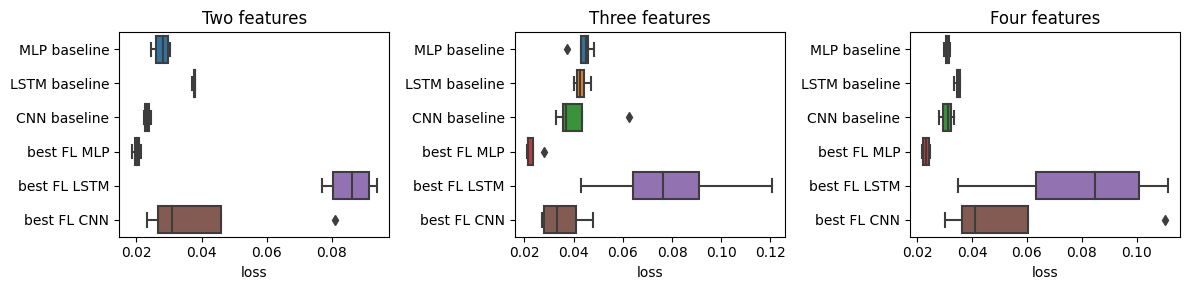

In [84]:
fig, axes = plt.subplots(1,3, figsize=(12,3))

results_only_best_fl_df = fl_models_df.copy(deep=True)
results_only_best_fl_df["losses_distributed"] = results_only_best_fl_df["losses_distributed"].apply(lambda x: x[-1][-1])
results_only_best_fl_df["model"] = results_only_best_fl_df["model"].apply(lambda x: f"best FL {x}")

#two features
temp_df = baseline_df.copy(deep=True)
temp_df["model"] = temp_df["model"].apply(rename_baseline_models)
temp_df = temp_df[["model", "client_data2"]]
temp_df.columns = ["model", "losses_distributed"]

temp_df = pd.concat([temp_df, results_only_best_fl_df[results_only_best_fl_df.number_of_clients == 2]], ignore_index=True)

temp_df = temp_df[["model", "losses_distributed"]]
temp_df.columns = ["model", "loss"]


sns.boxplot(temp_df, x="loss", y="model", ax=axes[0])
axes[0].set_ylabel("")
axes[0].set_title("Two features")

#three features
temp_df = baseline_df.copy(deep=True)
temp_df["model"] = temp_df["model"].apply(rename_baseline_models)
temp_df = temp_df[["model", "client_data3"]]
temp_df.columns = ["model", "losses_distributed"]

temp_df = pd.concat([temp_df, results_only_best_fl_df[results_only_best_fl_df.number_of_clients == 3]], ignore_index=True)

temp_df = temp_df[["model", "losses_distributed"]]
temp_df.columns = ["model", "loss"]


sns.boxplot(temp_df, x="loss", y="model", ax=axes[1])
axes[1].set_ylabel("")
axes[1].set_title("Three features")

#four features
temp_df = baseline_df.copy(deep=True)
temp_df["model"] = temp_df["model"].apply(rename_baseline_models)
temp_df = temp_df[["model", "client_data4"]]
temp_df.columns = ["model", "losses_distributed"]

temp_df = pd.concat([temp_df, results_only_best_fl_df[results_only_best_fl_df.number_of_clients == 4]], ignore_index=True)

temp_df = temp_df[["model", "losses_distributed"]]
temp_df.columns = ["model", "loss"]


sns.boxplot(temp_df, x="loss", y="model", ax=axes[2])
axes[2].set_ylabel("")
axes[2].set_title("Four features")

plt.tight_layout()
#plt.savefig("exports/covid/covid_fl_results.svg")
plt.show()


<AxesSubplot: xlabel='loss', ylabel='model'>

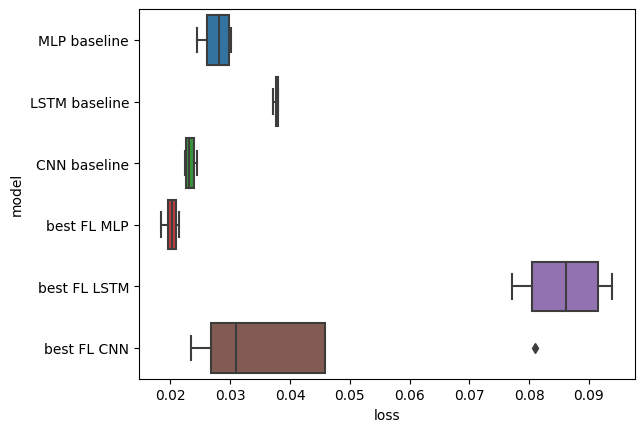

In [62]:
sns.boxplot(temp_df, x="loss", y="model")

In [144]:
temp_df

,model,loss
0,MLP baseline,0.026645
1,MLP baseline,0.029665
2,MLP baseline,0.030154
3,MLP baseline,0.024513
4,LSTM baseline,0.037183
5,LSTM baseline,0.037997
6,LSTM baseline,0.037995
7,LSTM baseline,0.037827
8,CNN baseline,0.022443
9,CNN baseline,0.023767


In [ ]:
results_fl_baseline_df = pd.DataFrame(columns=["model", "mean (two features)", "mean (three features)", "mean (four features)"])

In [ ]:
#add all FL results to the DataFrame

two_feature_mean =  results_only_best_fl_df[(results_only_best_fl_df.model == "best FL MLP") & (results_only_best_fl_df.number_of_clients == 2)].losses_distributed.mean()
three_feature_mean = results_only_best_fl_df[(results_only_best_fl_df.model == "best FL MLP") & (results_only_best_fl_df.number_of_clients == 3)].losses_distributed.mean()
four_feature_mean = results_only_best_fl_df[(results_only_best_fl_df.model == "best FL MLP") & (results_only_best_fl_df.number_of_clients == 4)].losses_distributed.mean()

results_fl_baseline_df = pd.concat([results_fl_baseline_df, pd.DataFrame({"model": "FL MLP", "mean (two features)": two_feature_mean, "mean (three features)": three_feature_mean, "mean (four features)": four_feature_mean}, index=[0])], ignore_index=True)


two_feature_mean =  results_only_best_fl_df[(results_only_best_fl_df.model == "best FL LSTM") & (results_only_best_fl_df.number_of_clients == 2)].losses_distributed.mean()
three_feature_mean = results_only_best_fl_df[(results_only_best_fl_df.model == "best FL LSTM") & (results_only_best_fl_df.number_of_clients == 3)].losses_distributed.mean()
four_feature_mean = results_only_best_fl_df[(results_only_best_fl_df.model == "best FL LSTM") & (results_only_best_fl_df.number_of_clients == 4)].losses_distributed.mean()

results_fl_baseline_df = pd.concat([results_fl_baseline_df, pd.DataFrame({"model": "FL LSTM", "mean (two features)": two_feature_mean, "mean (three features)": three_feature_mean, "mean (four features)": four_feature_mean}, index=[0])], ignore_index=True)


two_feature_mean =  results_only_best_fl_df[(results_only_best_fl_df.model == "best FL CNN") & (results_only_best_fl_df.number_of_clients == 2)].losses_distributed.mean()
three_feature_mean = results_only_best_fl_df[(results_only_best_fl_df.model == "best FL CNN") & (results_only_best_fl_df.number_of_clients == 3)].losses_distributed.mean()
four_feature_mean = results_only_best_fl_df[(results_only_best_fl_df.model == "best FL CNN") & (results_only_best_fl_df.number_of_clients == 4)].losses_distributed.mean()

results_fl_baseline_df = pd.concat([results_fl_baseline_df, pd.DataFrame({"model": "FL CNN", "mean (two features)": two_feature_mean, "mean (three features)": three_feature_mean, "mean (four features)": four_feature_mean}, index=[0])], ignore_index=True)

In [ ]:
#add all baseline results to the DataFrame

two_feature_mean = baseline_df[baseline_df.model == "MLP"].client_data2.mean()
three_feature_mean = baseline_df[baseline_df.model == "MLP"].client_data3.mean()
four_feature_mean = baseline_df[baseline_df.model == "MLP"].client_data4.mean()

results_fl_baseline_df = pd.concat([results_fl_baseline_df, pd.DataFrame({"model": "Baseline MLP", "mean (two features)": two_feature_mean, "mean (three features)": three_feature_mean, "mean (four features)": four_feature_mean}, index=[0])], ignore_index=True)


two_feature_mean = baseline_df[baseline_df.model == "LSTM"].client_data2.mean()
three_feature_mean = baseline_df[baseline_df.model == "LSTM"].client_data3.mean()
four_feature_mean = baseline_df[baseline_df.model == "LSTM"].client_data4.mean()

results_fl_baseline_df = pd.concat([results_fl_baseline_df, pd.DataFrame({"model": "Baseline LSTM", "mean (two features)": two_feature_mean, "mean (three features)": three_feature_mean, "mean (four features)": four_feature_mean}, index=[0])], ignore_index=True)


two_feature_mean = baseline_df[baseline_df.model == "CNN"].client_data2.mean()
three_feature_mean = baseline_df[baseline_df.model == "CNN"].client_data3.mean()
four_feature_mean = baseline_df[baseline_df.model == "CNN"].client_data4.mean()

results_fl_baseline_df = pd.concat([results_fl_baseline_df, pd.DataFrame({"model": "Baseline CNN", "mean (two features)": two_feature_mean, "mean (three features)": three_feature_mean, "mean (four features)": four_feature_mean}, index=[0])], ignore_index=True)

In [85]:
results_fl_baseline_df

,model,mean (two features),mean (three features),mean (four features)
0,FL MLP,0.020143,0.023096,0.023202
1,FL LSTM,0.085836,0.079060,0.079026
2,FL CNN,0.041619,0.035404,0.055643
3,Baseline MLP,0.027744,0.043782,0.030937
4,Baseline LSTM,0.037750,0.043084,0.034729
5,Baseline CNN,0.023310,0.042258,0.030922


In [ ]:
results_fl_baseline_df.to_latex("exports/covid/covid_results.tex")

In [145]:
_ ,p_value = scipy.stats.mannwhitneyu(temp_df[temp_df.model == "MLP baseline"]["loss"], temp_df[temp_df.model == "best FL MLP"]["loss"])
p_value

0.02857142857142857

The all FL models beat the baseline models. The FL MLPs and CNNs are also really interesting. "best FL MLP/CNN" hyperparameters are based on the best performing models during the FL test run. "optimal FL MLP/CNN" are use the optimal hyperparameters found by the centralized hyperparameter tuning. The difference between the models is only minimal, despite them having a different amount of hidden layers, and likely due to the random initialization. The "optimal FL MLP" is a little better than "best FL MLP" but has a higher variance.

It seems FL produces better models than centralized training with multiple combined datasets. How well does FL perform when compared to centralized training with less combined datasets? 

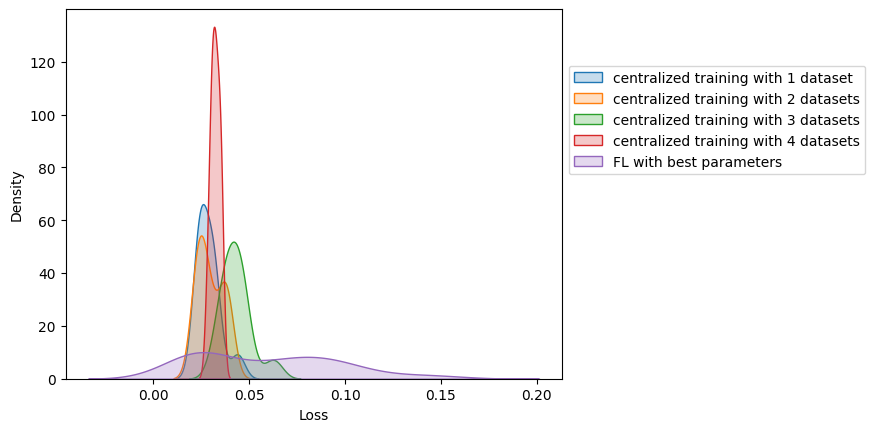

In [146]:
fig = sns.kdeplot(baseline_df["client_data1"], fill=True, label="centralized training with 1 dataset")
fig = sns.kdeplot(baseline_df["client_data2"], fill=True, label="centralized training with 2 datasets")
fig = sns.kdeplot(baseline_df["client_data3"], fill=True, label="centralized training with 3 datasets")
fig = sns.kdeplot(baseline_df["client_data4"], fill=True, label="centralized training with 4 datasets")
fig = sns.kdeplot(results_only_best_fl_df["losses_distributed"], fill=True, label="FL with best parameters")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xlabel("Loss")
plt.show()

In [42]:
best_optimal_fl_dist_df = pd.DataFrame(([
    ["FL with best parameters", results_only_best_fl_df["losses_distributed"].mean(), results_only_best_fl_df["losses_distributed"].std(), results_only_best_fl_df["losses_distributed"].skew(), results_only_best_fl_df["losses_distributed"].kurtosis()],
    ["FL with optimal parameters", results_only_optimal_fl_df["losses_distributed"].mean(), results_only_optimal_fl_df["losses_distributed"].std(), results_only_optimal_fl_df["losses_distributed"].skew(), results_only_optimal_fl_df["losses_distributed"].kurtosis()]
]), columns=["scenario", "mean", "std", "skew", "kurtosis"])

pd.concat([baseline_fl_dist_df.iloc[:4], best_optimal_fl_dist_df], ignore_index=True)

NameError: name 'results_only_optimal_fl_df' is not defined

This plot shows clearly the advantage of FL over centralized learning. It also suggests that the hyperparameters found by the hyperparameter tuning are a better choice than that found while performing the tests.

Now, how do the training times look like?

In [41]:
def calculate_training_time(time_array):
    #get the timestamps
    timestamps = []
    for el in time_array:
        timestamps.append(el[-1])
    
    #calculate difference
    diff = []
    for i in range(len(timestamps)):
        if i == len(timestamps)-1:
            break
        diff.append((timestamps[i+1] - timestamps[i]))
    return diff

time_diff_best_fl_df = best_fl_models.copy(deep=True)
time_diff_best_fl_df["time"] = time_diff_best_fl_df["time"].apply(calculate_training_time)
time_diff_best_fl_df["time"] = time_diff_best_fl_df["time"].apply(lambda x: np.array(x).mean())
time_diff_best_fl_df["model"] = time_diff_best_fl_df["model"].apply(lambda x: f"best FL {x}")


time_diff_optimal_fl_df = optimal_fl_models.copy(deep=True)
time_diff_optimal_fl_df["time"] = time_diff_optimal_fl_df["time"].apply(calculate_training_time)
time_diff_optimal_fl_df["time"] = time_diff_optimal_fl_df["time"].apply(lambda x: np.array(x).mean())
time_diff_optimal_fl_df["model"] = time_diff_optimal_fl_df["model"].apply(lambda x: f"optimal FL {x}")

In [47]:
baseline_time_df = pd.DataFrame(columns=["model", "time"])

for i in range(1,5):
    temp_df = baseline_df[["model", f"client_time{i}"]].copy(deep=True)
    temp_df["model"] = temp_df["model"].apply(lambda x: "baseline linear regression" if x == "linear_regression" else f"baseline {x}")
    temp_df.columns = ["model", "time"]

    baseline_time_df = pd.concat([baseline_time_df, temp_df], ignore_index=True)

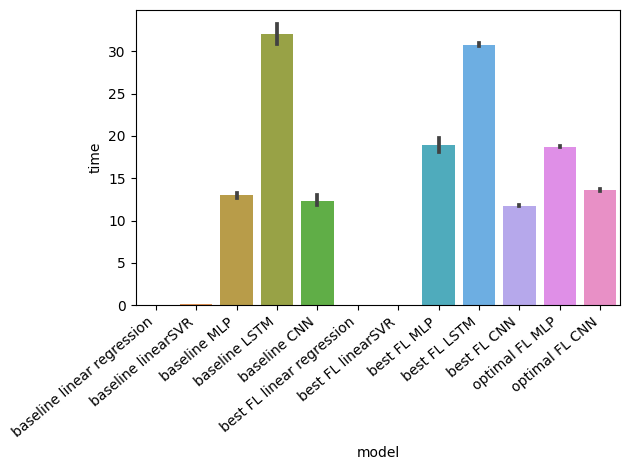

In [53]:
ax = sns.barplot(pd.concat([baseline_time_df, time_diff_best_fl_df, time_diff_optimal_fl_df], ignore_index=True), y="time", x="model")

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

Linear regression and linearSVR are almost instantly trained, when compared to the neural networks. There doesn't seem to be a clear pattern. The baseline MLP is better than the FL versions, but the LSTM is slightly worse. The rest is very similar to each other. It also important to note that the way of measuring time cannot be implemented the same way for FL and the baselines. Also, this is only a small number of models and therefore not representative for these model architectures.